In [1]:
from glob import glob
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import pickle
import eddytools as et
from cmocean import cm
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import timedelta
import matplotlib.colors as colors
import scipy.stats as stats
from matplotlib import axes
import seawater as sw
import xoak
import math

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
path_obs='/scratch/usr/shkifmmp/master/data/observations/'

In [3]:
save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/acc_statistics/'

In [4]:
mask_acc = xr.open_dataset('/scratch/usr/shkifmmp/master/data/ORION10/mask/mask_nest_int_2d.nc', chunks={"y":100, "x":100})

In [5]:
mask_plot = mask_acc.mask_nest.where(mask_acc.mask_nest ==0, other=1)

mask_plot = mask_plot.where(mask_plot.nav_lat >= -65, other=0)

In [ ]:
mask_plot

In [6]:
mask_plot.nav_lon.isel(y=0).values

array([ 75.5       ,  75.59999847,  75.69999695, ..., 431.40000153,
       431.5       , 431.59999847])

In [6]:
mask_test = mask_plot.where(mask_plot.nav_lon <=360, drop=True)

mask_test_aux = mask_plot.where(mask_plot.nav_lon >360, drop=True)

mask_test_aux.coords['nav_lon'].values = mask_test_aux.nav_lon.values - 360

mask_obs= xr.concat([mask_test_aux, mask_test], 'x')

In [7]:
mask_obs.xoak.set_index(['nav_lon','nav_lat'], "s2point")

### preparing data

In [8]:
cyc_o = xr.open_dataset(path_obs + 'cyclones.nc')

In [9]:
ant_o = xr.open_dataset(path_obs + 'anticyclones.nc')

In [10]:
ant_o = ant_o.drop_vars(['Chl','dChl','Chl_bg','Day', 'Year', 'Month'])

ant_o = ant_o.where((ant_o.Lat<=-37),drop=True)

ant_o = ant_o.where((ant_o.Lon>=75.5) | (ant_o.Lon<=71.6),drop=True)

In [11]:
cyc_o = cyc_o.drop_vars(['Chl','dChl','Chl_bg','Day', 'Year', 'Month'])

cyc_o = cyc_o.where((cyc_o.Lat<=-37),drop=True)

cyc_o = cyc_o.where((cyc_o.Lon>=75.5) | (cyc_o.Lon<=71.6),drop=True)

In [12]:
ant_lifetime = ant_o.groupby(ant_o.Eddy_id).last().Eddy_tsp

In [13]:
cyc_lifetime = cyc_o.groupby(cyc_o.Eddy_id).last().Eddy_tsp

In [15]:
ant_lat = ant_o.groupby(ant_o.Eddy_id).first().Lat
ant_lon = ant_o.groupby(ant_o.Eddy_id).first().Lon

ant_dia = ant_o.groupby(ant_o.Eddy_id).max().Dia

In [16]:
ant_o_lat = ant_o.groupby(ant_o.Eddy_id).last().Lat
ant_o_lon = ant_o.groupby(ant_o.Eddy_id).last().Lon

In [17]:
cyc_o_lat = cyc_o.groupby(cyc_o.Eddy_id).last().Lat
cyc_o_lon = cyc_o.groupby(cyc_o.Eddy_id).last().Lon

In [18]:
cyc_lat = cyc_o.groupby(cyc_o.Eddy_id).first().Lat
cyc_lon = cyc_o.groupby(cyc_o.Eddy_id).first().Lon

cyc_dia = cyc_o.groupby(cyc_o.Eddy_id).max().Dia

In [19]:
ant_pos = xr.Dataset(
    data_vars=dict(lifetime=(['Eddy_id'], ant_lifetime.values),
                  diameter=(['Eddy_id'], ant_dia.values),
                  lon=(['Eddy_id'], ant_lon.values),
                  lat=(['Eddy_id'], ant_lat.values),
                  lon_end=(['Eddy_id'], ant_o_lon.values),
                  lat_end=(['Eddy_id'], ant_o_lat.values)))

In [20]:
cyc_pos = xr.Dataset(
    data_vars=dict(lifetime=(['Eddy_id'], cyc_lifetime.values),
                  diameter=(['Eddy_id'], cyc_dia.values),
                  lon=(['Eddy_id'], cyc_lon.values),
                  lat=(['Eddy_id'], cyc_lat.values),
                  lon_end=(['Eddy_id'], cyc_o_lon.values),
                  lat_end=(['Eddy_id'], cyc_o_lat.values)))

In [21]:
ant_pos = ant_pos.where(ant_pos.lifetime >=4, drop=True)

In [22]:
cyc_pos = cyc_pos.where(cyc_pos.lifetime >=4, drop=True)

In [49]:
# ant_pos.to_netcdf(path=path_obs + 'ant_2.nc')

# cyc_pos.to_netcdf(path=path_obs + 'cyc_2.nc')

### getting eddies only on the mask

In [9]:
# cyc = xr.open_dataset(path_obs + 'cyc_2.nc')

In [11]:
# ant = xr.open_dataset(path_obs + 'ant_2.nc')

In [23]:
cyc_xo = mask_obs.xoak.sel(nav_lat= cyc_pos.lat, nav_lon=cyc_pos.lon).values

In [24]:
ant_xo = mask_obs.xoak.sel(nav_lat= ant_pos.lat, nav_lon=ant_pos.lon).values

In [23]:
ant_xo.shape, cyc_xo.shape

((44128,), (39434,))

In [25]:
ant_xo = xr.DataArray(data=ant_xo, dims=['Eddy_id'])

In [26]:
cyc_xo = xr.DataArray(data=cyc_xo, dims=['Eddy_id'])

In [27]:
cyc_pos = cyc_pos.where(cyc_xo, drop=True)

In [28]:
ant_pos = ant_pos.where(ant_xo, drop=True)

In [29]:
ant_pos

<xarray.Dataset>
Dimensions:   (Eddy_id: 27666)
Dimensions without coordinates: Eddy_id
Data variables:
    lifetime  (Eddy_id) float64 10.0 4.0 4.0 11.0 8.0 ... 4.0 4.0 4.0 4.0 4.0
    diameter  (Eddy_id) float64 66.7 80.66 73.45 78.82 ... 61.51 57.98 95.17
    lon       (Eddy_id) float64 18.0 28.5 35.25 49.15 ... 255.2 287.5 305.3
    lat       (Eddy_id) float64 -50.0 -56.5 -56.75 ... -64.73 -64.79 -56.94
    lon_end   (Eddy_id) float64 19.5 27.93 35.88 51.21 ... 255.7 288.5 305.9
    lat_end   (Eddy_id) float64 -49.5 -56.62 -56.75 ... -64.52 -64.62 -57.21

In [96]:
# ant.to_netcdf(path=path_obs + 'ant.nc')

# cyc.to_netcdf(path=path_obs + 'cyc.nc')

In [84]:
# ant_pos = ant_pos.where(ant_xo, drop=True)

In [94]:
ant = ant.assign(dict(lat_e=ant_pos.lat_end, lon_e=ant_pos.lon_end))

In [95]:
cyc = cyc.assign(dict(lat_e=cyc_pos.lat_end, lon_e=cyc_pos.lon_end))

In [85]:
# cyc_pos = cyc_pos.where(cyc_xo, drop=True)

## statistics

In [98]:
# ant['lifetime'] = ant.lifetime * 7

In [99]:
# ant = xr.open_dataset(path_obs + 'ant.nc')

In [58]:
# cyc['lifetime'] = cyc.lifetime * 7

In [31]:
cyc_p = cyc_pos.to_dataframe()

In [30]:
ant_p = ant_pos.to_dataframe()

In [34]:
def add_properties(eddies):
    for i in eddies.index:
        lat = [eddies.loc[i, 'lat'], eddies.loc[i, 'lat_end']]
        lon = [eddies.loc[i, 'lon'], eddies.loc[i, 'lon_end']]
        eddies.loc[i, 'distance'] = sw.extras.dist(lat,lon)[0]
        eddies.loc[i, 'speed'] = (eddies.loc[i, 'distance'] *1e5)/ (eddies.loc[i, 'lifetime']* 24 * 3600) # cm/s
    return eddies

In [35]:
cyc_p = add_properties(cyc_p)

In [36]:
ant_p = add_properties(ant_p)

In [37]:
ant_p.to_pickle(path= path_obs + 'anticyclonic_processed_diamMAX.pkl')

In [38]:
cyc_p.to_pickle(path= path_obs + 'cyclonic_processed_diamMAX.pkl')

In [148]:
cyc_p.distance.max()

2248.8271521836823

In [141]:
# cyc_p = cyc_p.loc[cyc_p.speed != 0]

In [142]:
# ant_p = ant_p.loc[ant_p.speed != 0]

In [14]:
ant_p =ant

In [15]:
cyc_p = cyc

### plotting

In [27]:
def plot_hist(variable, h_type, dist='pdf'):
    
    ant = ant_p
    cyc = cyc_p
    
    if h_type == 'normal':
        if variable == 'lifetime':
            interval = 15
        elif variable == 'speed':
            interval = 0.1
        elif variable == 'diameter':
            interval = 1
        elif variable == 'distance':
            interval = 5
        
        if type(interval) == float or type(interval) == int:
                bins_c = math.ceil((cyc[variable].max() - cyc[variable].min()) / interval)
                bins_a = math.ceil((ant[variable].max() - ant[variable].min()) / interval)
        else:
                bins_c = interval
                bins_a = interval
    
        y_c, bins_c = np.histogram(cyc[variable], bins=bins_c)
        y_a, bins_a = np.histogram(ant[variable], bins=bins_a)
        mean_a = ant[variable].mean()
        mean_c = cyc[variable].mean()
        
    elif h_type == 'ratio':
#         if type(interval) == float or type(interval) == int:
        if variable == 'diameter':
            interval = 5
            var_min, var_max = 44, 168
        elif variable == 'speed':
            interval = 0.5
            var_min, var_max = 0.023, 13.5
        elif variable == 'distance':
            interval = 10
            var_min, var_max = 1.16, 1599
        elif variable == 'lifetime':
            interval = 30
            var_min, var_max = 28, 400
        bins_c = math.ceil((var_max - var_min) / interval)
                    
#         else:
#             bins_c = interval
                
        y_c, bins_c = np.histogram(cyc.loc[(cyc[variable] <= var_max) & (cyc[variable] >= var_min)][variable], bins=bins_c)
        y_a, bins_a = np.histogram(ant.loc[(ant[variable] <= var_max) & (ant[variable] >= var_min)][variable], bins=bins_c)
        mean_a = ant[variable].mean()
        mean_c = cyc[variable].mean()
    
    bincenters_c= 0.5*(bins_c[1:]+bins_c[:-1])
    bincenters_a= 0.5*(bins_a[1:]+bins_a[:-1])
                         
    fig, axs = plt.subplots(figsize=(12,8))

    if h_type == 'normal':
        axs.plot(bincenters_c, y_c, label= 'Cyclonic', color='mediumblue', linewidth=2)
        axs.plot(bincenters_a, y_a, label= 'Anticyclonic', color='red', linewidth=2)
                         
        axs.set_ylabel('Number of eddies', fontsize=24)
        
        if dist == 'log':
            plt.yscale('log')     
        
        axs.set_ylim(bottom=1e0)
        axs.axvline(x=mean_a, color='red', linestyle='--', linewidth=2)
        axs.axvline(x=mean_c, color='mediumblue', linestyle='--', linewidth=2)
        
        leg = plt.legend(fontsize=20)
        for line in leg.get_lines():
            line.set_linewidth(2)
                         
    elif h_type == 'ratio':
        axs.plot((bincenters_c + bincenters_a)/2, (y_c/26377)/(y_a/27607), label='Observations', color= 'midnightblue', linewidth=2)
        axs.axhline(y=1, color='k', linestyle='--')

        axs.set_ylabel('Ratio Cyclonic/Anticyclonic', fontsize=24)
        axs.set_ylim(bottom=0.25,top=1.75)
                         
        if variable == 'speed' or variable == 'lifetime':
            axs.set_xlim(left=0)
    #         leg = axs.legend(fontsize=18)
        
    if variable == 'distance':
        axs.set_xlabel('Pathway length (km)', fontsize=24)
        axs.set_xlim(right=400, left=0)
        axs.set_ylim(bottom=10)
        save_title = 'distance'
        
        if h_type == 'ratio':
            axs.set_ylim(bottom=0.25, top=1.75)
        
    elif variable == 'lifetime':
        axs.set_xlabel('Lifetime (weeks)', fontsize=24)
        save_title = 'lifetime'
        axs.set_xlim(right=365, left=30) #left=30
        if h_type == 'normal':
            axs.set_ylim(bottom=1e1)
        
        labels= ['7', '14', '21', '28', '35', '42', '49']
        axs.set_xticks([49, 98, 147, 196, 245, 294, 343])
        axs.set_xticklabels(labels)
#         if h_type == 'ratio':
#             axs.set_ylim(top=2)

    elif variable == 'diameter':
        axs.set_xlabel('Mean diameter (km)', fontsize=24)
        save_title='meandiameter'
        axs.set_xlim(right=140)
        axs.set_xlim(left=20)

        
    elif variable == 'speed':
        axs.set_xlabel('Propagation speed (cm$\,$s$^{-1}$)', fontsize=24)
        save_title='speed'
        axs.set_xlim(left=0, right=5)
        if dist == 'log':
            axs.set_ylim(bottom=1e1)
        
    axs.tick_params(axis= 'x', labelsize= 24)
    axs.tick_params(axis= 'y', labelsize= 24)
    axs.grid()
    
#     for line in leg.get_lines():
#         line.set_linewidth(2)
        
    plt.savefig(save_path + '220225/'+ 'statistics_obs_'+ save_title + '_' + h_type + '_' + dist + '_' + str(interval) + 'interval.png', format='png', facecolor="w",  bbox_inches='tight')

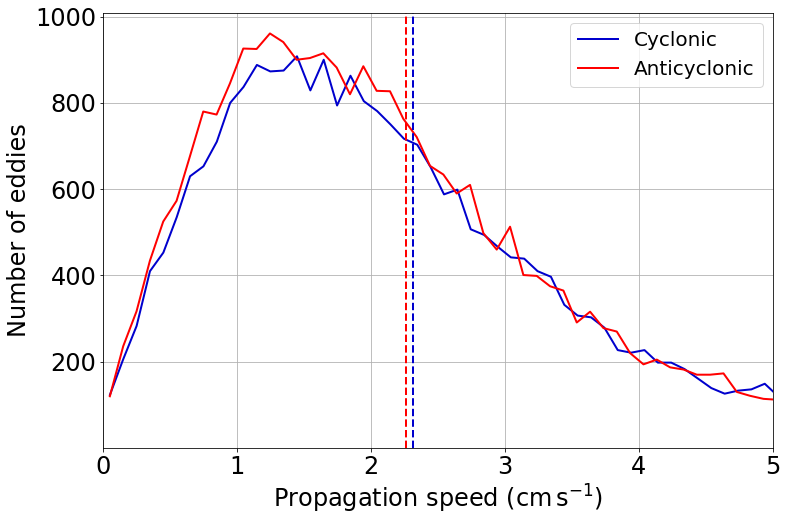

In [37]:
plot_hist('speed','normal')

In [256]:
stats.ks_2samp(eddy_FO.loc[eddy_FO['type'] == 'anticyclonic'].life_time.astype('timedelta64[D]').values, ant_p.lifetime.values)

KstestResult(statistic=0.1992610569783026, pvalue=0.0)

In [258]:
stats.ks_2samp(eddy_FO.loc[eddy_FO['type'] == 'cyclonic'].speed.values, cyc_p.speed.values)

KstestResult(statistic=0.04337270623226164, pvalue=1.657912819610254e-29)

In [241]:
eddy_OR.loc[eddy_OR['type'] == 'anticyclonic'].life_time.astype('timedelta64[D]').values

array([130.,  55.,  45., ...,  30.,  30.,  30.])

In [7]:
def open_eddy_stat(model, time_start, time_end):
    lon1= 77.5
    lon2= 69.5
    datapath = '/scratch/usr/shkifmmp/master/data/'
    datapath_f = datapath + model
    time_i = str(time_start)
    time_e = str(time_end)
    with open(datapath_f + '/eddies_detect/acc/eddy_stat_' + time_i + '_' + time_e +  '.pkl', 'rb') as f:
        eddy_stat  = pickle.load(f)
        f.close()
    return eddy_stat

In [219]:
eddy_OR = open_eddy_stat('ORION10', 1998, 2017)

In [234]:
eddy_OR.loc[eddy_OR['type'] == 'anticyclonic'].scale_mean.values * 2

array([ 38.40093779,  66.54946465,  29.76431356, ...,  35.04196681,
        98.50240446, 142.59836402])

In [221]:
eddy_FO = open_eddy_stat('ORION10X', 1998, 2017)

In [38]:
x=ant_p.lon.values
y=ant_p.lat.values

xy = np.vstack([x, y])
z = stats.kde.gaussian_kde(xy)(xy)
idx = z.argsort()

x2, y2, z = x[idx], y[idx], z[idx]

In [39]:
mask_plot = mask_acc.mask_nest.where(mask_acc.mask_nest ==0, other=1)

mask_plot = mask_plot.where(mask_plot.nav_lat > -65, other=0)
mask_plot = mask_plot.where(mask_plot.nav_lon > 75.5, other=0)
mask_plot = mask_plot.where(mask_plot.nav_lon < 431.58, other=0)

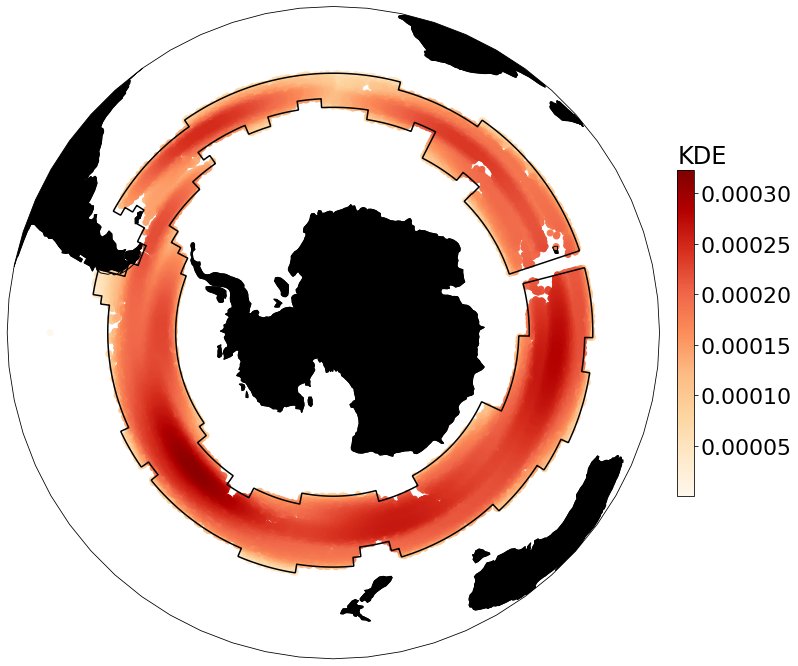

In [45]:
fig, axs = plt.subplots(figsize=(16,12), subplot_kw = {'projection': ccrs.NearsidePerspective(central_latitude = -90)})

axs.contour(mask_acc.nav_lon, mask_acc.nav_lat, mask_plot, transform= ccrs.PlateCarree(),
            colors='black', levels=[1], linewidth=15, zorder=7)

map1 = axs.scatter(x=x2, y=y2, c=z,transform= ccrs.PlateCarree(), cmap='OrRd',
                  vmin=z_c.min(), vmax=z_c.max())

axs.set_global()
axs.coastlines()
axs.add_feature(cfeature.LAND, color='black')

c = plt.colorbar(map1, pad=0.02, shrink=0.5, ax=axs)
c.ax.set_title('KDE', loc='left', fontsize=24)
c.ax.tick_params(labelsize=22)
axes.Axes.tick_params(axs, axis='both' ,labelsize=22)

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/acc_statistics/'
plt.savefig(savepath + 'obs_anti_maps_OrRd_kde.png', format='png', facecolor="w", bbox_inches='tight')

In [41]:
x_c=cyc_p.lon.values
y_c=cyc_p.lat.values

xy_c = np.vstack([x_c, y_c])
z_c = stats.kde.gaussian_kde(xy_c)(xy_c)
idx_c = z_c.argsort()

x2_c, y2_c, z_c = x_c[idx_c], y_c[idx_c], z_c[idx_c]

In [266]:
z_c.min(), z_c.max(), z.min(), z.max()

(5.923124963105431e-07,
 0.00032430093507191776,
 3.6720858569998424e-07,
 0.00031218436708579163)

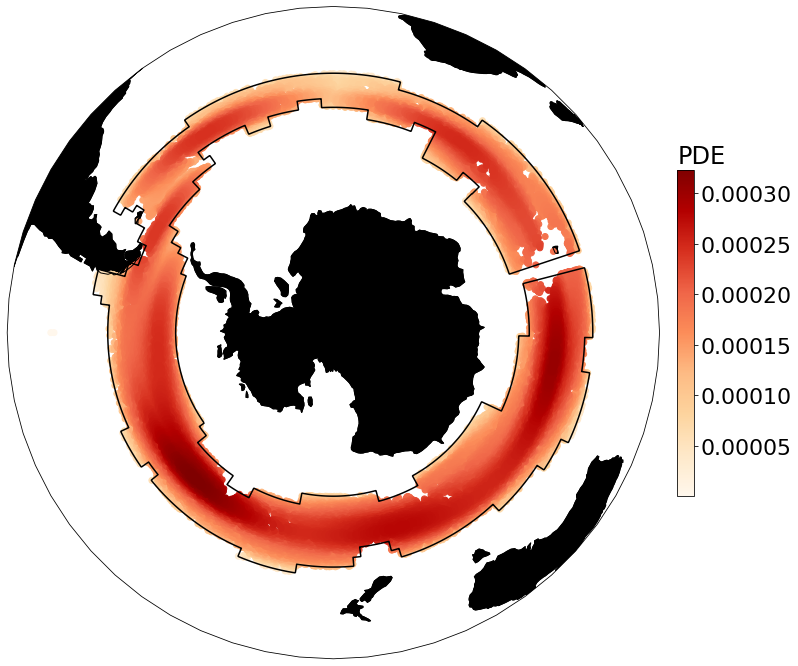

In [44]:
fig, axs = plt.subplots(figsize=(16,12), subplot_kw = {'projection': ccrs.NearsidePerspective(central_latitude = -90)})

axs.contour(mask_acc.nav_lon, mask_acc.nav_lat, mask_plot, transform= ccrs.PlateCarree(),
            colors='black', levels=[1], linewidth=15, zorder=7, vmin=z_c.min(), vmax=z_c.max())

map1 = axs.scatter(x=x2_c, y=y2_c, c=z_c,transform= ccrs.PlateCarree(), cmap='OrRd')

axs.set_global()
axs.coastlines()
axs.add_feature(cfeature.LAND, color='black')

c = plt.colorbar(map1, pad=0.02, shrink=0.5, ax=axs)
c.ax.set_title('KDE', loc='left', fontsize=24)
c.ax.tick_params(labelsize=22)
# axes.Axes.tick_params(axs, axis='both' ,labelsize=18)

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/acc_statistics/'
plt.savefig(savepath + 'obs_cyc_maps_OrRd.png', format='png', facecolor="w", bbox_inches='tight')

In [9]:
with open(path_obs + 'anticyclonic_processed.pkl', 'rb') as f:
        ant  = pickle.load(f)
        f.close()

with open(path_obs + 'cyclonic_processed.pkl', 'rb') as f:
        cyc  = pickle.load(f)
        f.close()

In [5]:
ant.count()

lifetime    27666
diameter    27666
lon         27666
lat         27666
lat_e       27666
lon_e       27666
distance    27666
speed       27666
dtype: int64

In [8]:
cyc.loc[cyc.lifetime >= 365].count()

lifetime    120
diameter    120
lon         120
lat         120
lat_e       120
lon_e       120
distance    120
speed       120
dtype: int64

In [6]:
27666/26303

1.051819184123484